In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

running_dir = r"/Users/4JStudent/Desktop/Code/Bens_Tetris_Regression"

In [2]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [3]:
## Dataloading
df = pd.read_csv (os.path.join(running_dir, "sprint_data.csv"))
df.columns = df.columns.str.lower()
df["normalized_pps"] = df["approxpps"].map (lambda x: 1 / (1 + np.exp(-x)))

df.head()



,timescorekaiyon,replay,played3,datestart,approxpps,dayssincestart,ln(days),ln(pps),normalized_pps
0,247.775,11409815,2020-02-10 4:13:34,2020-02-09,0.403592,1.176088,0.162194,-0.907351,0.599550
1,210.933,11410692,2020-02-11 4:13:34,2020-02-09,0.474084,2.176088,0.777529,-0.746370,0.616350
2,188.721,11410748,2020-02-12 4:13:34,2020-02-09,0.529883,3.176088,1.155650,-0.635100,0.629456
3,163.329,11446804,2020-02-11 4:16:08,2020-02-09,0.612261,2.177870,0.778348,-0.490596,0.648456
4,157.704,11447133,2020-02-11 4:26:21,2020-02-09,0.634099,2.184965,0.781600,-0.455550,0.653418


<AxesSubplot: xlabel='ln(days)', ylabel='ln(pps)'>

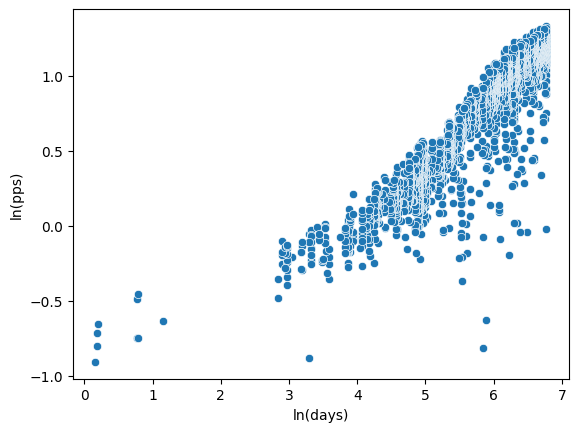

In [5]:
sns.scatterplot (df, x="ln(days)", y="ln(pps)")

Parameters [ 0.20232706 -0.31876217 -1.63124651]
RMSE: 0.16134231830590087
R-squared: 0.8532028289690423


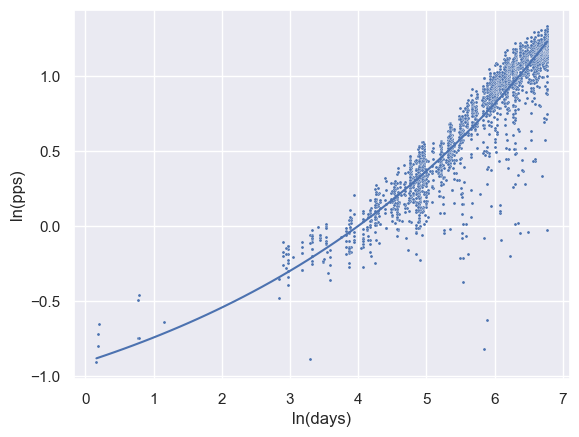

In [35]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

xData = df["ln(days)"]
yData = df["ln(pps)"]

def func(x, a, b, Offset):
  return np.power (np.e, (a*x + b)) + Offset
    # return a * x + b


def sumOfSquaredError(parameterTuple):
    warnings.filterwarnings("ignore") 
    val = func(xData, *parameterTuple)
    return numpy.sum((yData - val) ** 2.0)


def generate_Initial_Parameters():
    maxX = max(xData)
    minX = min(xData)
    maxY = max(yData)
    minY = min(yData)

    parameterBounds = []
    parameterBounds.append([minX, maxX]) 
    parameterBounds.append([minX, maxX]) 
    parameterBounds.append([0.0, maxY]) 

    result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
    return result.x

geneticParameters = generate_Initial_Parameters()
fittedParameters, pcov = curve_fit(func, xData, yData, geneticParameters)

print('Parameters', fittedParameters)

modelPredictions = func(xData, *fittedParameters) 

absError = modelPredictions - yData

SE = numpy.square(absError) 
MSE = numpy.mean(SE) 
RMSE = numpy.sqrt(MSE) 
Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
print('RMSE:', RMSE)
print('R-squared:', Rsquared)



def ModelAndScatterPlot(graphWidth, graphHeight):
    xModel = numpy.linspace(min(xData), max(xData))
    yModel = func(xModel, *fittedParameters)
    
    sns.set_theme()
    sns.scatterplot (df, x="ln(days)", y="ln(pps)", s=5)

    # plt.plot(xData, yData,  'D')
    plt.plot(xModel, yModel)

    plt.show()
    plt.close('all') 

graphWidth = 800
graphHeight = 600
ModelAndScatterPlot(graphWidth, graphHeight)

# 


In [10]:
def custom_regression (xData, yData, func, p0):
    fittedParameters, pcov = curve_fit(func, xData, yData, p0)
    modelPredictions = func(xData, *fittedParameters) 
    absError = modelPredictions - yData
    SE = numpy.square(absError) 
    MSE = numpy.mean(SE) 
    RMSE = numpy.sqrt(MSE) 
    Rsquared = 1.0 - (numpy.var(absError) / numpy.var(yData))
    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)
    return fittedParameters, pcov

In [4]:
import torch
import torch.nn as nn
class RegressionModel (nn.Module):
  def __init__ (self, param_names: list):
    super ().__init__()
    self.initialize_weights(len(param_names))
    self.layer = nn.Linear (1, 1)

    # Paramaters
    exec (
      ", ".join(f"self.{name}" for name in param_names) + ' = ' + 
      ", ".join(
        [
          f'nn.Parameter(self.weights[{i}])' 
          for i in range (len(param_names))
          ]
      )
    )

  # Weights
  def initialize_weights (self, n):
    self.weights = [nn.init.uniform (torch.empty (1)) for i in range (n)]

  # Function
  def forward (self, x):
    # return self.a * x + self.b
    return 
    # return self.layer (x)

    

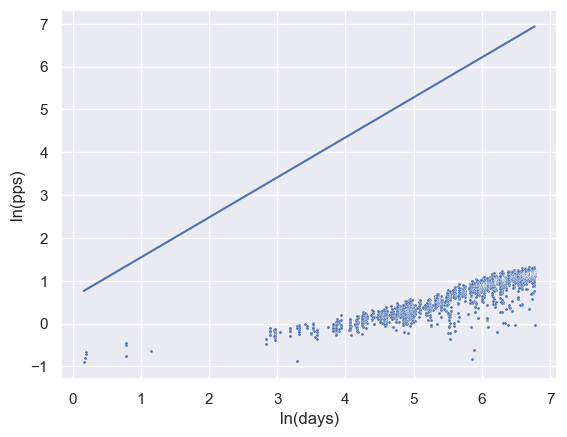

100%|██████████| 40/40 [00:00<00:00, 7217.56it/s]


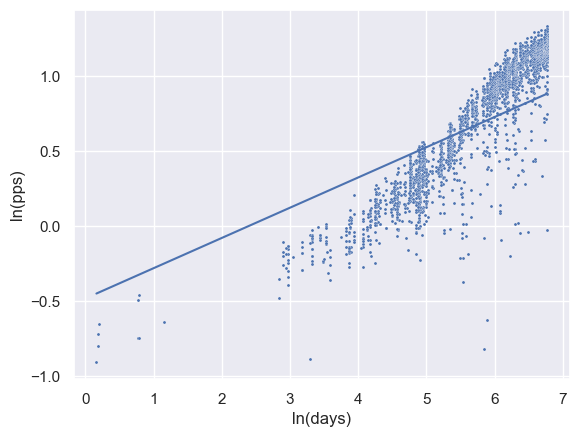

In [34]:

params = ["a", "b", "c"]
model = RegressionModel (params)

optimizer = torch.optim.Adam (model.parameters(), lr=0.2)
criterion = nn.L1Loss()

def plot_regression (df, model, min_scale=0, max_scale=10):
  sns.set_theme()
  sns.scatterplot (df, x="ln(days)", y="ln(pps)", s=5)

  xModel = torch.linspace(min_scale, max_scale, steps=500)
  yModel = model(xModel)
  # print (yModel)

  plt.plot(xModel.detach(), yModel.detach())
  plt.show()
  plt.close('all')

def train_regression (model, data, epochs=1, optimizer=None, criterion=None):
    for i in tqdm(range (epochs)):
      x, y = torch.unsqueeze(data[0], 1), torch.unsqueeze(data[1], 1)
      # for x, y in zip(x_data, y_data):      
        # print (f"{x.shape=} {y.shape=}")
        # print (f"{x=} {y=}")
      y_pred = model(x.type (torch.DoubleTensor))
      loss = criterion(y_pred, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


xData, yData = torch.tensor(df["ln(days)"]), torch.tensor(df["ln(pps)"])
plot_regression (df, model, min(xData), max(xData))
train_regression (model, (xData, yData), epochs=40, optimizer=optimizer, criterion=criterion)
plot_regression (df, model, min(xData), max(xData))
